In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
from scipy import special
import scipy.constants as const
import astropy.constants as aconst
import random
from time import monotonic
# from mpl_toolkits.mplot3d import Axes3D

In [2]:
def rozklad(nsteps,rho,v):
    ints[0] = rho[0]*dr*r[0]**2
    for i in range(nsteps):
        # kick
        vi = v[i]-9*r[i]*rho[i]*dr/2.
        ri = r[i]+dr/2.
        # drift
        rho[i+1] = rho[i]*np.exp(vi/ri**2*dr)
        # kick
        v[i+1] = vi-9*r[i]*rho[i+1]*dr/2.
        
        r[i+1] = r[i]+dr
        ints[i+1] = rho[i+1]*dr*r[i+1]**2
        if rho[i+1] < 10e-6:
            break
    return r, rho, v, ints

def random_theta(F):
    return np.arccos(1-2*F)

def random_gauss(F, sigma, mu):
    return sigma*np.sqrt(2)*special.erfinv(2*F-1)+mu

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [3]:
params = {'font.size': 16,
          'figure.figsize': (12.,8.),
          'axes.labelsize': 16,
          'xtick.labelsize': 16,
          'ytick.labelsize': 16
         }
plt.rcParams.update(params)

In [4]:
pc = aconst.pc.value # m
m2pc = 1/pc
M_sun = aconst.M_sun.value # kg
kg2Ms = 1/M_sun
Myr = const.Julian_year*10**6 # s
s2Myr = 1/Myr
G = const.G*(m2pc)**3*(kg2Ms)**(-1)*(s2Myr)**(-2) # pc3 M_s-1 Myr-2

nsteps = 120000
nbody = 100000
D = 15000
sigma = 125
mu = 0.

dr = 0.001

r = np.zeros(nsteps+1) # t
rho = np.zeros(nsteps+1) # r
v = np.zeros(nsteps+1) # v
ints = np.zeros(nsteps+1) # dystrybuanta
mi = np.zeros(nbody)

ri = 0.
vi = 0.
mi[:] = 10e+13
M = mi[0]*nbody

r[0] = 0.
rho[0] = 1
v[0] = 0
ints[0] = rho[0]*dr*r[0]**2

start = monotonic()
r, rho, v, ints = rozklad(nsteps,rho,v)
end = monotonic()
print(f"Czas kompilacji: {end-start} s")

ints /= ints[-1]

Czas kompilacji: 0.4149225440000919 s


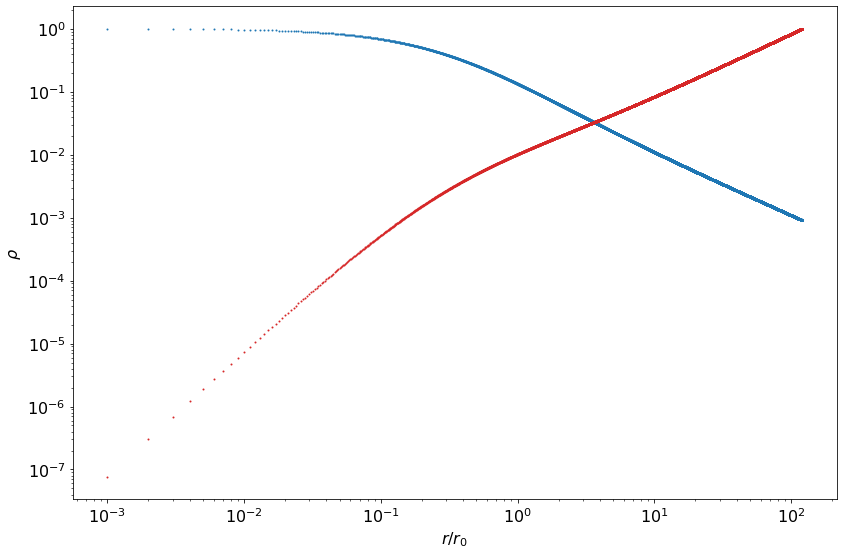

In [5]:
plt.figure(1, tight_layout=True)

plt.scatter(r, rho, s=1, c='tab:blue', label="gęstość rozkładu")
plt.scatter(r, ints, s=1, c='tab:red', label="dystrybuanta")

plt.xscale('log')
plt.yscale('log')

plt.xlabel(r"$r/r_0$")
plt.ylabel(r"$\rho$")

plt.savefig("rho_dyst.pdf", bbox_inches='tight')

In [6]:
rho0 = 0.025
r0 = np.sqrt(9*sigma**2/(4*np.pi*G*rho0))
print(r0)

x = np.zeros(nbody)
y = np.zeros(nbody)
z = np.zeros(nbody)
vx = np.zeros(nbody)
vy = np.zeros(nbody)
vz = np.zeros(nbody)

dyst_r = np.random.uniform(0, 1, size=nbody)
dyst_theta = np.random.uniform(0, 1, size=nbody)
theta = random_theta(dyst_theta)
phi = np.random.uniform(0, 2*np.pi, size=nbody)

start = monotonic()
for i in range(nbody):
    idx = find_nearest(ints, dyst_r[i])
    x[i] = r[idx]*r0*np.cos(phi[i])*np.sin(theta[i])
    y[i] = r[idx]*r0*np.sin(phi[i])*np.sin(theta[i])
    z[i] = r[idx]*r0*np.cos(theta[i])
        
dyst_v = np.random.uniform(0, 1, size=3*nbody)
random_v = random_gauss(dyst_v, sigma, mu)
vx[:] = random_v[0::3]
vy[:] = random_v[1::3]
vz[:] = random_v[2::3]
end = monotonic()
print(f"Czas kompilacji: {end-start} s")

9975.217299825623
Czas kompilacji: 13.246528133000083 s


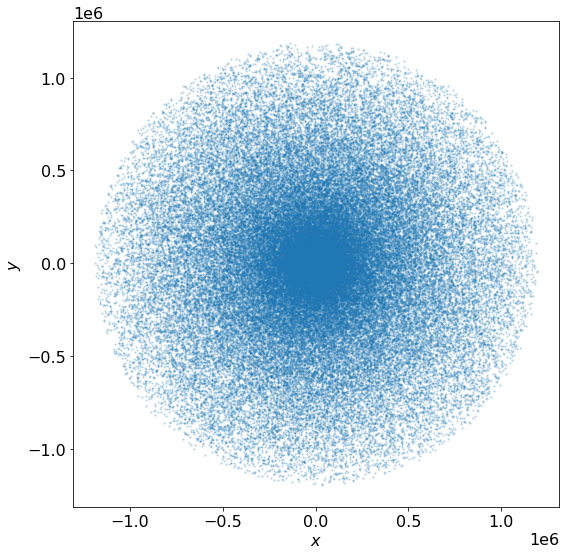

In [7]:
plt.figure(2, tight_layout=True)

plt.scatter(x, y, s=2, alpha=0.2)

plt.xlabel("$x$")
plt.ylabel("$y$")
plt.gca().set_aspect('equal', 'box')

plt.savefig("rozklad_xy.pdf", bbox_inches='tight')

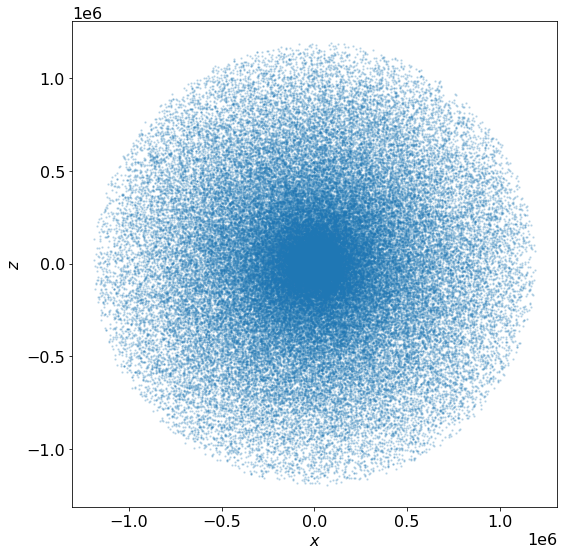

In [8]:
plt.figure(3, tight_layout=True)

plt.scatter(x, z, s=2, alpha=0.2)

plt.xlabel("$x$")
plt.ylabel("$z$")
plt.gca().set_aspect('equal', 'box')

plt.savefig("rozklad_xz.pdf", bbox_inches='tight')

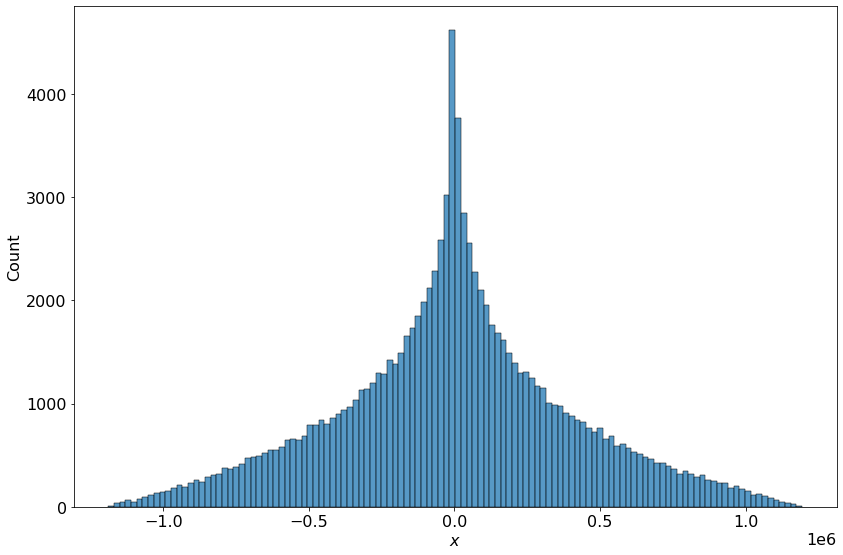

In [9]:
plt.figure(4, tight_layout=True)

sns.histplot(x, color='tab:blue')

plt.xlabel("$x$")

plt.savefig("rozklad_x.pdf", bbox_inches='tight')

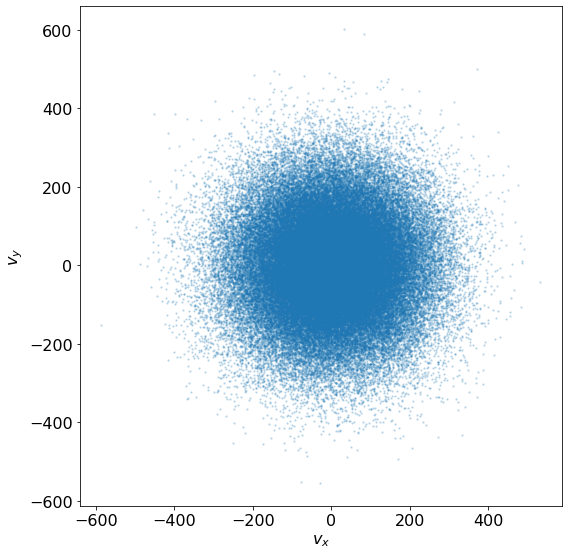

In [10]:
plt.figure(5, tight_layout=True)

plt.scatter(vx, vy, s=2, alpha=0.2)

plt.xlabel("$v_x$")
plt.ylabel("$v_y$")
plt.gca().set_aspect('equal', 'box')

plt.savefig("rozklad_vxvy.pdf", bbox_inches='tight')

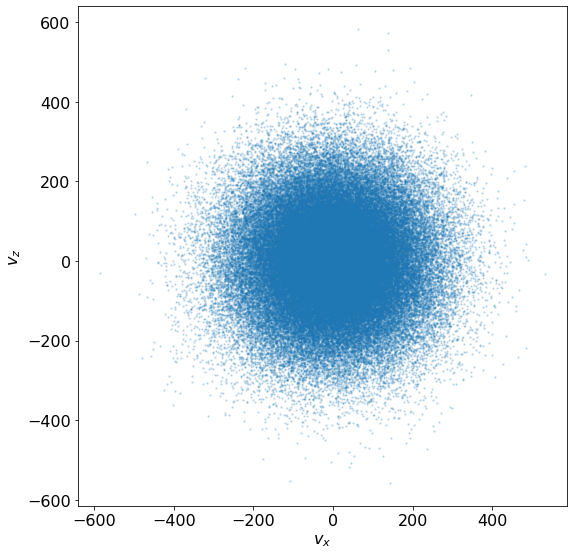

In [11]:
plt.figure(6, tight_layout=True)

plt.scatter(vx, vz, s=2, alpha=0.2)

plt.xlabel("$v_x$")
plt.ylabel("$v_z$")
plt.gca().set_aspect('equal', 'box')

plt.savefig("rozklad_vxvz.pdf", bbox_inches='tight')

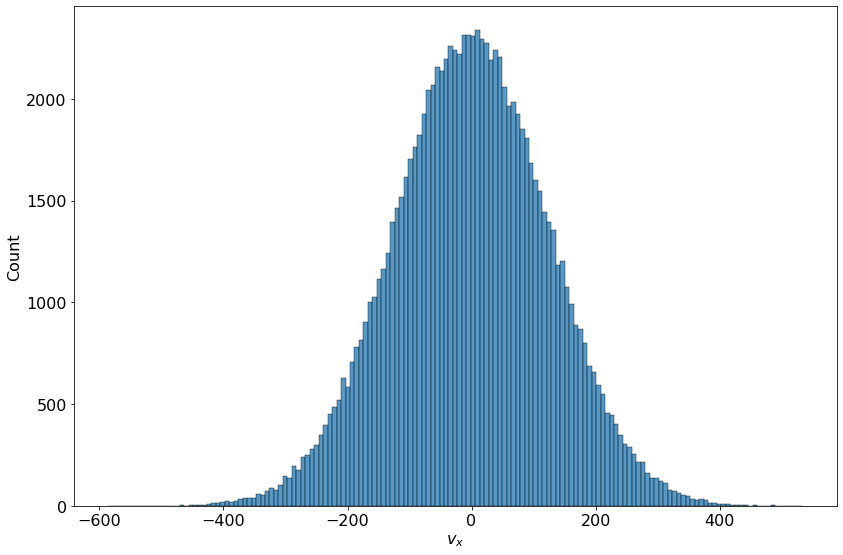

In [12]:
plt.figure(7, tight_layout=True)

sns.histplot(vx, color='tab:blue')

plt.xlabel("$v_x$")

plt.savefig("rozklad_vx.pdf", bbox_inches='tight')

In [13]:
f = open('orbit-8_new.dat', "w")
f.write(f"{nbody} 0 0\n")
for i in range(nbody):
    f.write(f"{mi[i]}\n")
for i in range(nbody):
    for i in range(3):
        f.write(f"{x[i]} ")
        f.write(f"{y[i]} ")
        f.write(f"{z[i]} \n")
for i in range(nbody):
    for i in range(3):
        f.write(f"{vx[i]} ")
        f.write(f"{vy[i]} ")
        f.write(f"{vz[i]} \n")
f.close()